In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objs as go

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
spot=pd.read_csv('long-term-spx-vix.csv')
#spot=spot.set_index(spot.columns[0])
spot.head()
training_data=spot.dropna()
training_data=training_data.reset_index(drop=True)
training_data=training_data.set_index(training_data.columns[0])
training_data=training_data.interpolate(method='time')
training_data.head()

,SPX INDEX,VIX INDEX
EffectiveDate,,
1990-01-02,359.69,17.24
1990-01-03,358.76,18.19
1990-01-04,355.67,19.22
1990-01-05,352.20,20.11
1990-01-08,353.79,20.26


In [3]:
spot=pd.read_csv('long-term-spx-vix.csv')
v = spot['SPX INDEX']
SPX_realvol = np.log(v/v.shift()).rolling(22).std() * np.sqrt(260)
spot['Realised vol']=SPX_realvol
VIX_INDEX = spot['VIX INDEX'] * 1e-2
train=spot
train['VIX INDEX']=train['VIX INDEX'] * 1e-2
train=train.dropna()
train.head()

,EffectiveDate,SPX INDEX,VIX INDEX,Realised vol
15551,1990-01-02,359.69,0.1724,0.121350
15552,1990-01-03,358.76,0.1819,0.121051
15553,1990-01-04,355.67,0.1922,0.118352
15554,1990-01-05,352.20,0.2011,0.123483
15555,1990-01-08,353.79,0.2026,0.122816


In [4]:
x=list(train['VIX INDEX'])
y=np.array(train['Realised vol'])

print(x[0:5])

[0.1724, 0.1819, 0.19219999999999998, 0.2011, 0.20260000000000003]


In [5]:
class piece_wise_LR:
  def __init__(self,x,y,n):
    """
    x: x
    y: y
    n: number of segments
    """
    self.x=list(x)
    self.y=np.array(y)
    self.n=n

    #sort distinct x
    x_set_id=[self.x.index(i) for i in set(self.x)]
    x_set=[self.x[i] for i in x_set_id]
    y_set=np.array([self.y[i] for i in x_set_id])
    x_idx=list(np.argsort(x_set))
    x_set=sorted(x_set)
    y_set=list(y_set[x_idx])
    

    #plot presentations:
    tck = interpolate.splrep(x_set, y_set, k=2, s=0)
    xnew = np.linspace(min(x),max(x))

    fig, axes = plt.subplots(3,figsize=(15, 18))
    axes[0].plot(x_set, y_set, 'x', label = 'data')
    axes[0].plot(xnew, interpolate.splev(xnew, tck, der=0), label = 'Initial Fit')

    axes[1].plot(x_set, interpolate.splev(x_set, tck, der=1), label = '1st dev')
    dev_2 = interpolate.splev(x_set, tck, der=2)
    axes[2].plot(x_set, dev_2, label = '2st dev')
    for ax in axes:
      ax.legend(loc = 'best')

    #decide knots according to number of segments
    n_knot=self.n-1
    knot_idx=np.argsort(dev_2)[0:n_knot]
    self.knot=[x_set[i] for i in knot_idx]



  def piecewise_LR(self):
    sort_knot=list(sorted(self.knot))
    sort_knot=[min(self.x),*sort_knot,max(self.x)]

    #piecewise OLS regression
    sns.set(rc={'figure.figsize':(10,8)})
    sns.scatterplot(x=self.x, y=self.y,color='pink')

    for i in range(self.n):
      left,right=sort_knot[i],sort_knot[i+1]
      X_id=[k for k in range(len(self.x)) if self.x[k]>=left and self.x[k]<right]
      X=np.array(self.x)[X_id]
      Y=np.array(self.y)[X_id]
      X_ = sm.add_constant(X)
      model = sm.OLS(Y,X_)
      results = model.fit()
      predict_y=list(np.array(results.predict(X_)).flatten())
      
      print("Regression Summary for Segment ",i)
      print(results.summary())

      sns.lineplot(X, predict_y,label='Segment '+str(i+1))
    

    plt.title("Piecewise Linear Regression")
    plt.show()
    return None

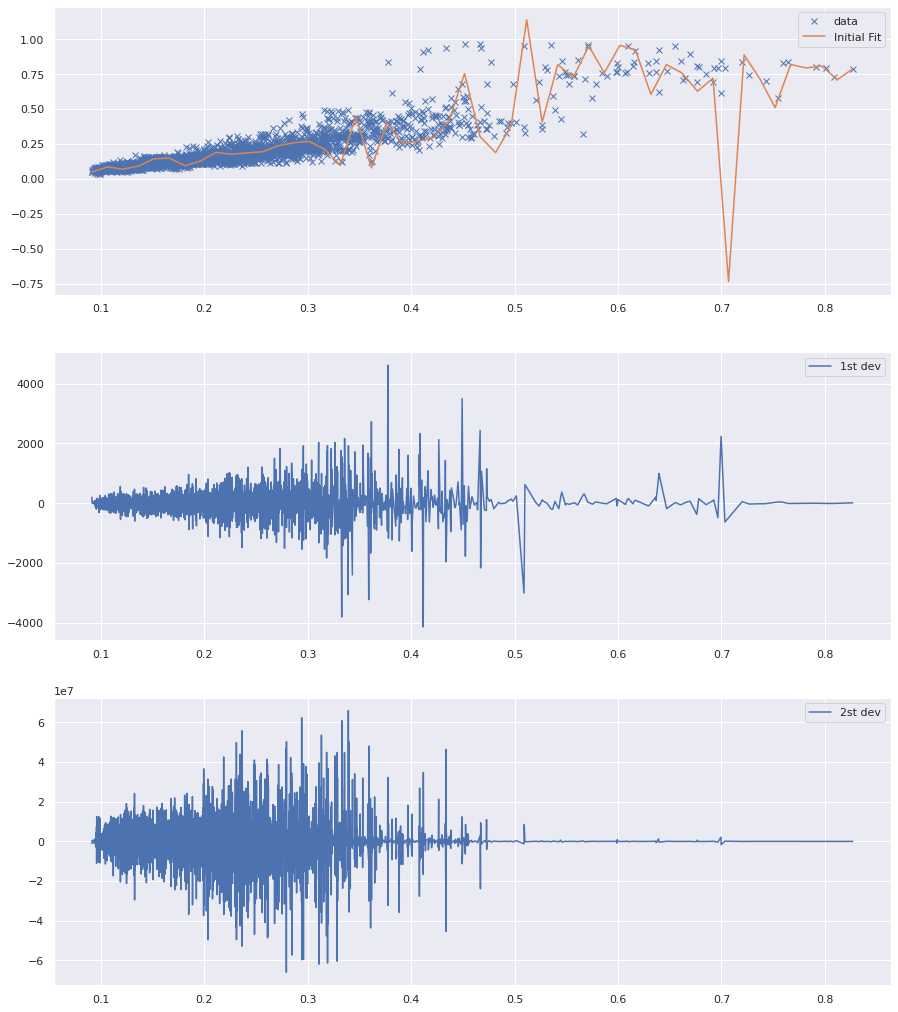

In [ ]:
#automatic knots decisions
LR=piece_wise_LR(x,y,3)

(6800,)
Regression Summary for Segment  0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                 1.003e+04
Date:                Fri, 15 Jan 2021   Prob (F-statistic):               0.00
Time:                        20:11:51   Log-Likelihood:                 13339.
No. Observations:                6800   AIC:                        -2.667e+04
Df Residuals:                    6798   BIC:                        -2.666e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(316,)
Regression Summary for Segment  1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.007
Date:                Fri, 15 Jan 2021   Prob (F-statistic):              0.158
Time:                        20:12:20   Log-Likelihood:                 457.31
No. Observations:                 316   AIC:                            -910.6
Df Residuals:                     314   BIC:                            -903.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(575,)
Regression Summary for Segment  2
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     868.3
Date:                Fri, 15 Jan 2021   Prob (F-statistic):          7.28e-117
Time:                        20:12:22   Log-Likelihood:                 434.52
No. Observations:                 575   AIC:                            -865.0
Df Residuals:                     573   BIC:                            -856.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



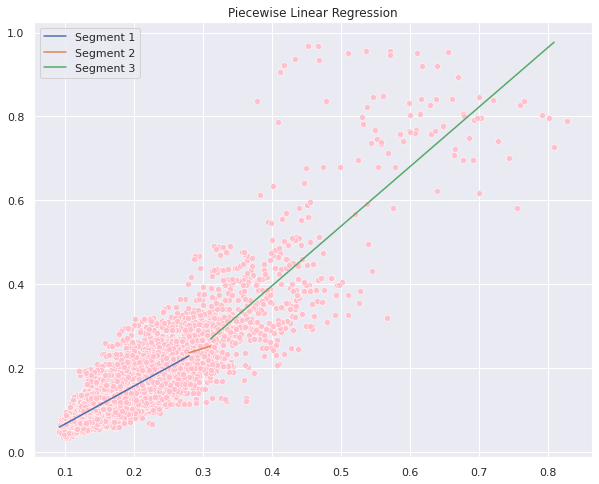

In [ ]:
re=LR.piecewise_LR()